# Modelling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row',50)

In [2]:
DATA_DIR = '../data'

In [3]:
data = pd.read_csv("{}/processed/dataset.csv".format(DATA_DIR))

In [4]:
LABEL = 'roi'

In [5]:
train = data[~pd.isnull(data["points"])]
train["roi"] = train["roi"].fillna(0)
test = data[pd.isnull(data["points"])]

<ipython-input-5-97c2e041d959>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["roi"] = train["roi"].fillna(0)


In [6]:
train.shape

(7137, 114)

In [7]:
test.shape

(634, 114)

In [8]:
train.head()

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
0,Aaron Ramsey,2018-09-06 00:00:00,UEFA Nations League,Wales,Republic of Ireland,21.00,90.0,M,2018,9,6,7.0,8.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,19,1536,26,29,1484,0.0,2.0,2.0,0.0,4.0,3.0,25.6,1.767500e+09,68000000.0,25.5,7.765000e+08,29900000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,52,-10,9.910000e+08,38100000.0,0.1,True,False,1.0,0.823529,False,High,High
1,Aaron Ramsey,2018-09-09 00:00:00,UEFA Nations League,Wales,Denmark,13.50,90.0,M,2018,9,9,2.0,8.5,3.0,7.0,1.0,0.0,7.000000,1.0,0.0,7.0,NaN,NaN,NaN,90.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,1.00,18,19,1536,9,9,1580,0.0,0.0,0.0,0.0,0.0,NaN,25.6,1.767500e+09,68000000.0,27.8,3.107000e+09,119500000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,-44,10,-1.339500e+09,-51500000.0,-2.2,True,False,1.0,0.235294,False,High,High
2,Aaron Ramsey,2018-10-11 00:00:00,International Friendlies,Wales,Spain,1.42,90.0,M,2018,10,11,2.0,8.5,3.0,2.0,0.0,0.0,4.500000,0.5,0.0,7.0,3.535534,0.707107,0.0,90.0,1.0,2.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,1.00,18,19,1536,6,9,1597,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,-61,10,NaN,NaN,NaN,False,False,1.0,0.235294,False,High,High
3,Aaron Ramsey,2018-11-16 00:00:00,UEFA Nations League,Wales,Denmark,2.96,90.0,M,2018,11,16,2.0,8.5,3.0,2.0,0.0,0.0,3.666667,0.0,0.0,7.0,2.886751,0.577350,0.0,90.0,1.0,3.0,0.0,0.0,0.0,4.0,0.0,2.0,2.0,0.75,18,18,1538,9,10,1584,0.0,1.0,0.0,0.0,2.0,2.0,25.6,1.767500e+09,68000000.0,27.8,3.107000e+09,119500000.0,26

In [9]:
train.columns

Index(['player', 'date', 'league_name', 'team_name', 'opponent_name',
       'fantasy_points', 'min', 'position', 'year', 'month',
       ...
       'diff_team_market_value', 'diff_team_mean_market_value',
       'diff_team_mean_squad_age', 'is_senior', 'is_imbalanced',
       'gap_to_potential', 'roi', 'more_likely_to_win', 'attacking_work_rate',
       'defending_work_rate'],
      dtype='object', length=114)

In [10]:
columns = ['player', 'league_name', 'date', 'year',
           'points', 'roi', 'value', 'min', 'nation_position',
           'last_md_assists', 'last_md_goals', 'prev_std_assists',
           'month', 'day', 'nation_jersey_number','team_name', 'opponent_name',
           'fantasy_points', 'prev_mean_goals', 'prev_median_min', "prev_std_goals",
           "prev_team_highest_rank" , "prev_opponent_highest_rank", "is_senior", 
           "hth_draw"]

In [11]:
fifa_col = ['attacking_crossing', 'attacking_finishing','attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'height_cm', 'weight_kg',
            'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
            'movement_reactions', 'movement_balance', 'power_shot_power',
            'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
            'mentality_aggression', 'mentality_interceptions',
            'mentality_positioning', 'mentality_vision', 'mentality_penalties',
            'mentality_composure', 'defending_standing_tackle',
            'defending_sliding_tackle', 'goalkeeping_diving',
            'goalkeeping_handling', 'goalkeeping_kicking',
            'goalkeeping_positioning', 'goalkeeping_reflexes']

In [12]:
columns += fifa_col

In [13]:
def train_model(df, dropped_cols, label, model):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    mae, mse = mean_absolute_error(y_test, prediction), mean_squared_error(y_test, prediction)
    print(model)
    print("MAE:", mae)
    print("MSE:", mse)
    

In [14]:
model = LGBMRegressor(random_state=1)

In [15]:
train_model(train,columns, "roi", model)

LGBMRegressor(random_state=1)
MAE: 0.29565174884611006
MSE: 0.17056662915085508


In [16]:
train_model(train,columns, "points", model)

LGBMRegressor(random_state=1)
MAE: 1.8405260699032735
MSE: 6.179467212036502


## The Dream Team

In [17]:
X_test = pd.get_dummies(test.drop(columns, axis=1))

In [18]:
def plotImp(model, X , num = 20, fig_size = (9, 3)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

In [19]:
def get_model(df, dropped_cols, label):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    y = df[label]
    model = LGBMRegressor(random_state=1)
    model.fit(X, y)
    print(X.columns)
    plotImp(model,X, 10)
    return model

Index(['skill', 'last_md_points', 'prev_mean_points', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_ratio_starter',
       'count_played', 'goal_consistency', 'assist_consistency',
       'clean_sheet_consistency', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'prev_ratio_played', 'team_rank',
       'team_total_points', 'opponent_rank', 'opponent_total_points',
       'hth_team_win', 'hth_opp_win', 'hth_team_score', 'hth_opp_score',
       'htt_max_margin', 'team_mean_squad_age', 'team_market_value',
       'team_mean_market_value', 'opponent_mean_squad_age',
       'opponent_market_value', 'opponent_mean_market_value', 'age',
       'league_rank', 'overall', 'potential', 'wage_eur',
       'international_reputation', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'diff_team_points', 'diff_team_ranking',
       'diff_team_market_value', 'dif

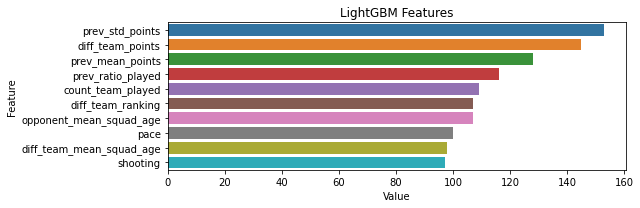

Index(['skill', 'last_md_points', 'prev_mean_points', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_ratio_starter',
       'count_played', 'goal_consistency', 'assist_consistency',
       'clean_sheet_consistency', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'prev_ratio_played', 'team_rank',
       'team_total_points', 'opponent_rank', 'opponent_total_points',
       'hth_team_win', 'hth_opp_win', 'hth_team_score', 'hth_opp_score',
       'htt_max_margin', 'team_mean_squad_age', 'team_market_value',
       'team_mean_market_value', 'opponent_mean_squad_age',
       'opponent_market_value', 'opponent_mean_market_value', 'age',
       'league_rank', 'overall', 'potential', 'wage_eur',
       'international_reputation', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'diff_team_points', 'diff_team_ranking',
       'diff_team_market_value', 'dif

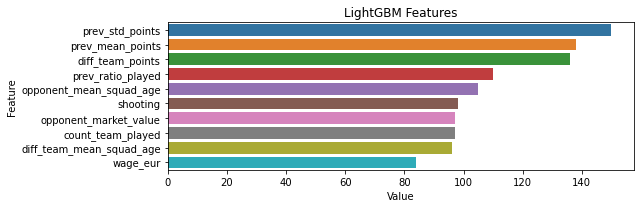

In [20]:
model_1 = get_model(train, columns,'roi')
model_2 = get_model(train, columns,'points')

In [21]:
X_test

,skill,last_md_points,prev_mean_points,prev_mean_assists,prev_max_points,prev_std_points,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,team_rank,team_total_points,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,physic,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_imbalanced,gap_to_potential,more_likely_to_win,position_D,position_F,position_GK,position_M,attacking_work_rate_High,attacking_work_rate_Low,attacking_work_rate_Medium,defending_work_rate_High,defending_work_rate_Low,defending_work_rate_Medium
8,3.0,3.0,3.875000,0.000000,13.0,4.155461,0.750000,8.0,0.125000,0.0,0.250000,27.0,NaN,NaN,NaN,0.296296,17,1570,13,1606,1.0,1.0,3.0,4.0,3.0,25.6,1.767500e+09,68000000.0,27.0,2.835000e+09,109000000.0,29.0,1.0,82.0,82.0,98000.0,3.0,68.0,77.0,79.0,80.0,68.0,73.0,-36,4,-1.067500e+09,-41000000.0,-1.4,False,0.0,False,0,0,0,1,1,0,0,1,0,0
16,3.0,1.0,2.000000,0.333333,4.0,1.732051,0.000000,3.0,0.000000,0.0,0.000000,29.0,NaN,NaN,NaN,0.103448,29,1505,7,1642,0.0,0.0,0.0,0.0,NaN,25.0,3.250000e+09,125000000.0,27.8,7.640000e+09,293800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-137,22,-4.390000e+09,-168800000.0,-2.8,True,NaN,False,0,0,0,1,0,0,0,0,0,0
19,1.0,1.0,1.000000,0.000000,1.0,0.000000,0.000000,2.0,0.000000,0.0,0.000000,27.0,NaN,NaN,NaN,0.074074,17,1570,13,1606,1.0,1.0,3.0,4.0,3.0,25.6,1.767500e+09,68000000.0,27.0,2.835000e+09,109000000.0,27.0,2.0,70.0,73.0,12000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-36,4,-1.067500e+09,-41000000.0,-1.4,False,3.0,False,0,0,1,0,0,0,1,0,0,1
20,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,1458,44,1441,1.0,4.0,4.0,7.0,1.0,27.4,1.900000e+09,73100000.0,27.3,2.698500e+09,103800000.0,17.0,1.0,74.0,87.0,500.0,1.0,77.0,71.0,68.0,75.0,32.0,73.0,17,-4,-7.985000e+08,-30700000.0,0.1,False,13.0,False,0,0,0,0,1,0,0,0,0,1
26,3.0,1.0,1.200000,0.000000,2.0,0.447214,0.200000,5.0,0.000000,0.0,0.000000,27.0,NaN,NaN,NaN,0.185185,6,1648,18,1569,1.0,0.0,4.0,1.0,3.0,26.5,9.150000e+09,381300000.0,29.2,2.150500e+09,82700000.0,24.0,1.0,79.0,85.0,80000.0,1.0,96.0,66.0,68.0,87.0,38.0,81.0,79,-12,6.999500e+09,298600000.0,-2.7,True,6.0,True,0,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7708,3.0,1.0,2.227273,0.045455,8.0,1.688387,0.909091,22.0,0.000000,0.0,0.272727,26.0,NaN,NaN,NaN,0.846154,37,1468,5,1666,0.0,2.0,3.0,7.0,3.0,28.1,7.485000e+08,28800000.0,27.9,8.725000e+09,335600000.0,25.0,2.0,72.0,77.0,29000.0,1.0,68.0,54.0,73.0,75.0,70.0,60.0,-198,32,-7.976500e+09,-306800000.0,0.2,True,5.0,False,0,0,0,1,0,0,1,1,0,0
7733,4.0,5.0,3.416667,0.083333,10.0,2.357535,0.958333,24.0,0.041667,0.0,0.291667,26.0,NaN,NaN,NaN,0.923077,37,1468,5,1666,0.0,2.0,3.0,7.0,3.0,28.1,7.485000e+08,28800000.0,27.9,8.725000e+09,335600000.0,32.0,1.0,71.0,71.0,18000.0,2.0,34.0,71.0,59.0,70.0,39.0,78.0,-198,32,-7.976500e+09,-306800000.0,0.2,True,0.0,False,0,1,0,0,0,0,1,0,0,1
7735,2.0,2.0,2.000000,0.000000,2.0,NaN,1.000000,1.0,0.000000,0.0,0.000000,26.0,NaN,NaN,NaN,0.038462,37,1468,5,1666,0.0,2.0,3.0,7.0,3.0,28.1,7.485000e+08,28800000.0,27.9,8.725000e+09,335600000.0,24.0,1.0,64.0,72.0,2000.0,1.0,52.0,31.0,43.0,39.0,65.0,71.0,-198,32,-7.976500e+09,-306800000.0,0.2,True,8.0,False,1,0,0,0,0,1,0,0,0,1
7752,4.0,2.0,3.312500,0.062500,10.0,2.701080,0.750000,16.0,0.062500,0.0,0.312500,27.0,1.0,5.0,5.0

In [22]:
test["predicted_roi"] = model_1.predict(X_test)
test["predicted_points"] = model_2.predict(X_test)

<ipython-input-22-d6009eb4ca09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_roi"] = model_1.predict(X_test)
<ipython-input-22-d6009eb4ca09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_points"] = model_2.predict(X_test)


## Surfacing The Result

In [23]:
fantasy_euro = pd.read_csv("{}/interim/fantasy_euro.csv".format(DATA_DIR))

In [24]:
fantasy_euro = fantasy_euro[["player", "date", "league_name", "team_name", 
                             "opponent_name", "value", "skill", "sel_per"]]

In [25]:
players = pd.merge(test, 
                   fantasy_euro[["player", "sel_per"]],
                   how='left', on="player")

In [26]:
players = players.drop_duplicates(subset=["player", "team_name"])

In [39]:
players = players[~pd.isnull(players['position'])]
players = players[players['prev_ratio_starter'] > 0.75]
players = players[players['prev_ratio_played'] > 0.7]

In [40]:
scaler = StandardScaler()
players["scaled_points"] = scaler.fit_transform(players["predicted_points"].values.reshape(-1,1))
players["scaled_roi"] = scaler.fit_transform(players["predicted_roi"].values.reshape(-1,1))

In [41]:
players["final_score"] = players["scaled_points"] * 0.7 + players["scaled_roi"] * 0.3

In [42]:
players = players.sort_values(by=["final_score"], ascending=False)

In [43]:
col = ["player", "team_name", "opponent_name", "position", 'hth_team_win', 'hth_opp_win', "value", "predicted_roi", "predicted_points", "final_score", "prev_max_points", "prev_mean_points", "prev_std_points", "prev_ratio_starter", "prev_ratio_played"]

In [44]:
views = players[col]

In [45]:
views[views["position"] == "GK"]

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
543,Rui Patrício,Portugal,Hungary,GK,2.0,0.0,5.5,0.741740,4.418304,1.867493,7.0,4.315789,2.473249,1.0,0.703704
214,Gianluigi Donnarumma,Italy,Turkey,GK,0.0,0.0,5.5,0.737288,3.997034,1.478679,7.0,4.894737,2.024701,1.0,0.703704
319,Kasper Schmeichel,Denmark,Finland,GK,1.0,0.0,5.0,0.671751,3.970388,1.295799,7.0,4.375000,2.355613,1.0,0.923077
646,Yann Sommer,Switzerland,Wales,GK,1.0,1.0,5.0,0.714981,3.512689,0.989957,14.0,4.095238,3.144913,1.0,0.807692
164,Dominik Livakovic,Croatia,England,GK,1.0,1.0,5.0,0.668688,3.417219,0.792000,7.0,3.277778,1.994273,1.0,0.720000
638,Wayne Hennessey,Wales,Switzerland,GK,1.0,1.0,5.0,0.728110,3.052467,0.608836,7.0,4.000000,2.357023,1.0,0.703704
586,Stole Dimitrievski,North Macedonia,Austria,GK,0.0,2.0,4.5,0.658061,2.828562,0.238011,7.0,3.500000,2.444625,1.0,0.814815
368,Lukás Hrádecky,Finland,Denmark,GK,0.0,1.0,4.0,0.648096,2.736573,0.131294,8.0,5.050000,2.163696,1.0,0.740741
500,Péter Gulácsi,Hungary,Portugal,GK,0.0,2.0,4.5,0.605914,2.740334,0.032350,7.0,3.526316,2.269812,1.0,0.730769
380,Manuel Neuer,Germany,France,GK,2.0,4.0,6.0,0.435887,3.143318,-0.018468,12.0,3.947368,3.099708,1.0,0.703704


In [38]:
views[(views["position"] == "D")].head(30)

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
69,Benjamin Pavard,France,Germany,D,4.0,2.0,6.0,0.821228,4.144551,1.833738,9.0,3.285714,2.629503,0.952381,0.750000
291,João Cancelo,Portugal,Hungary,D,2.0,0.0,6.0,0.634679,4.524786,1.760483,9.0,3.736842,2.725234,0.842105,0.703704
506,Raphael Varane,France,Germany,D,4.0,2.0,6.0,0.714933,4.266433,1.705615,8.0,3.958333,2.440227,0.916667,0.857143
505,Raphael Guerreiro,Portugal,Hungary,D,2.0,0.0,6.5,0.781517,4.016980,1.628096,6.0,4.176471,2.007339,0.941176,0.629630
549,Rúben Dias,Portugal,Hungary,D,2.0,0.0,6.0,0.702217,4.081201,1.508169,13.0,3.730769,3.000769,0.961538,0.962963
306,Kaan Ayhan,Turkey,Italy,D,0.0,0.0,5.0,0.715816,4.024685,1.487260,12.0,3.809524,3.544278,0.761905,0.724138
426,Mehmet Zeki Çelik,Turkey,Italy,D,0.0,0.0,4.5,0.816055,3.639814,1.362052,18.0,3.611111,4.272193,0.944444,0.620690
231,Harry Maguire,England,Croatia,D,1.0,1.0,5.5,0.563548,4.029197,1.148701,12.0,4.300000,3.357631,1.000000,0.740741
569,Stefan Lainer,Austria,North Macedonia,D,2.0,0.0,5.0,0.735316,3.514794,1.066405,11.0,4.000000,2.756810,0.952381,0.777778
253,Jan Bednarek,Poland,Slovakia,D,1.0,1.0,4.5,0.637840,3.701546,1.017255,6.0,2.590909,2.152719,0.954545,0.846154


In [37]:
views[(views["position"] == "M")].head(30)

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
70,Bernardo Silva,Portugal,Hungary,M,2.0,0.0,8.5,0.558392,4.528690,1.592362,11.0,4.240000,2.989983,0.880000,0.925926
226,Hakan Calhanoglu,Turkey,Italy,M,0.0,0.0,8.5,0.514384,4.564717,1.526160,10.0,4.090909,3.084664,0.909091,0.758621
597,Thomas Delaney,Denmark,Finland,M,1.0,0.0,5.5,0.597863,4.273130,1.448257,9.0,2.904762,1.972429,1.000000,0.807692
614,Tomas Soucek,Czech Republic,Scotland,M,1.0,4.0,6.5,0.456644,4.067599,0.943121,17.0,3.285714,3.730186,0.952381,0.807692
382,Marcel Sabitzer,Austria,North Macedonia,M,2.0,0.0,8.0,0.474642,3.756018,0.699633,8.0,2.894737,2.183136,0.894737,0.703704
603,Thorgan Hazard,Belgium,Russia,M,4.0,0.0,8.0,0.557728,3.473537,0.629148,12.0,3.850000,2.870448,0.850000,0.740741
76,Bruno Fernandes,Portugal,Hungary,M,2.0,0.0,10.5,0.490707,3.637014,0.627320,8.0,2.631579,2.060489,0.789474,0.703704
94,Christian Eriksen,Denmark,Finland,M,1.0,0.0,9.0,0.514397,3.523001,0.576717,16.0,5.333333,4.439611,0.916667,0.923077
210,Georginio Wijnaldum,Netherlands,Ukraine,M,0.0,0.0,8.0,0.416034,3.754635,0.566477,18.0,5.280000,4.596375,1.000000,0.925926
186,Enis Bardhi,North Macedonia,Austria,M,0.0,2.0,6.0,0.494901,3.397719,0.418653,8.0,3.714286,2.452404,0.952381,0.777778


In [36]:
views[views["position"] == "F"].head(20)

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
106,Cristiano Ronaldo,Portugal,Hungary,F,2.0,0.0,12.0,0.471353,4.960494,1.790052,18.0,5.736842,5.064496,0.947368,0.703704
518,Robert Lewandowski,Poland,Slovakia,F,1.0,1.0,11.5,0.413570,4.660919,1.386966,14.0,5.105263,3.710267,0.947368,0.730769
427,Memphis Depay,Netherlands,Ukraine,F,0.0,0.0,10.0,0.445569,4.156511,0.999236,16.0,5.666667,3.829708,1.000000,0.888889
230,Harry Kane,England,Croatia,F,1.0,1.0,11.5,0.353066,4.111416,0.749961,17.0,5.478261,4.541421,0.869565,0.851852
340,Kylian Mbappé,France,Germany,F,4.0,2.0,12.0,0.360913,3.627902,0.326920,12.0,3.900000,3.193744,0.800000,0.714286
466,Olivier Giroud,France,Germany,F,4.0,2.0,8.0,0.440239,3.327950,0.232049,10.0,3.653846,2.726790,0.769231,0.928571
207,Gareth Bale,Wales,Switzerland,F,1.0,1.0,9.5,0.358282,3.463426,0.171087,9.0,3.350000,2.455391,0.850000,0.740741
402,Martin Braithwaite,Denmark,Finland,F,1.0,0.0,7.5,0.391061,3.363562,0.153833,6.0,3.166667,1.761093,0.875000,0.923077
229,Haris Seferovic,Switzerland,Wales,F,1.0,1.0,8.5,0.369896,3.392255,0.132355,13.0,4.000000,3.144660,0.842105,0.730769
49,Antoine Griezmann,France,Germany,F,4.0,2.0,11.0,0.369562,3.256274,0.007664,10.0,4.071429,3.078342,0.928571,1.000000
